In [1]:
#Libraries import
import pandas as pd
from mordred import Calculator, descriptors
import mordred
import numpy as np
from rdkit import Chem

from sklearn.tree import DecisionTreeRegressor

from sklearn.model_selection import train_test_split

from sklearn.metrics import r2_score

from sklearn.decomposition import PCA

import matplotlib.pyplot as plt

import joblib

In [2]:
def prepare_data(file):
    
    df = pd.read_excel(file)
    
    try:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['SMILES']]
    except:
        mol_objs = [Chem.MolFromSmiles(smi) for smi in df['new_SMILES']]
    
    calculate_descriptors = True
    
    if calculate_descriptors:
        calc = Calculator(descriptors, ignore_3D=True)
        molecular_descriptors = calc.pandas(mol_objs)
        molecular_descriptors = molecular_descriptors.applymap(is_morder_missing)
        molecular_descriptors = molecular_descriptors[sorted(molecular_descriptors.columns)]
    else:
        pass
    print(molecular_descriptors.shape)
    
    simple_preprocessing = True
    if simple_preprocessing:
        molecular_descriptors_cleaned = molecular_descriptors.dropna(axis=1, how='any')
        molecular_descriptors_cleaned
    print(molecular_descriptors_cleaned.shape)
    molecular_descriptors_cleaned = molecular_descriptors_cleaned.loc[:, (molecular_descriptors_cleaned != 0).any(axis=0)]
    print(molecular_descriptors_cleaned.shape)
    
    try:
        molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]'] = df['Aktywność cytoprotekcyjna [%]']
    except:
        pass
    
    #try:
        #print('Target distribution histogram: ')
        #print(df['Aktywność cytoprotekcyjna [%]'].hist())
    #except:
        #pass
    
    return molecular_descriptors_cleaned

In [3]:
def is_morder_missing(x):
    return np.nan if type(x) == mordred.error.Missing or type(x) == mordred.error.Error else x 

In [4]:
def correlation_dataframe(molecular_descriptors_cleaned, correlation_threshold):
    
    correlation_table = pd.DataFrame(data=molecular_descriptors_cleaned.columns.to_list(), columns=["molecular descriptor name"])
    print(correlation_table.head())
    correlation_to_ak_cyt = []
    for mol_desc in correlation_table['molecular descriptor name']:
        x = np.corrcoef(np.array(molecular_descriptors_cleaned[mol_desc]), np.array(molecular_descriptors_cleaned['Aktywność cytoprotekcyjna [%]']))
        x = x.tolist()[0][1]
        correlation_to_ak_cyt.append(x)
    correlation_table['corr_value'] = correlation_to_ak_cyt
    print(correlation_table.head())
    correlation_table['absolute correlation value'] = [abs(x) for x in correlation_table['corr_value']]
    print(correlation_table[:-1].head())
    
    mol_desc_best_corr = correlation_table[correlation_table['absolute correlation value'] > correlation_threshold]
    
    print(mol_desc_best_corr.head())
    table_with_descriptors_to_be_used = mol_desc_best_corr[:-1]
    print(table_with_descriptors_to_be_used.head())
    
    #print("Correlation to the target histogram: ")
    #print(correlation_table['absolute correlation value'][:-1].hist(bins=100))
    
    return table_with_descriptors_to_be_used
    

In [5]:
def prepare_model(data, features, max_depth):
    
    X_train, X_test, y_train, y_test = train_test_split(data[features['molecular descriptor name']], 
                                                        data['Aktywność cytoprotekcyjna [%]'], 
                                                        test_size=0.05, random_state=42)
    
    dtr = DecisionTreeRegressor(random_state=15, max_depth=max_depth)
    
    dtr.fit(X_train, y_train)
    print("Return the coefficient of determination of the prediction: ")
    print(dtr.score(X_test, y_test))

    pred = dtr.predict(X_train)
    print("R^2 score: "+ str(r2_score(y_train, pred)))
    sqrt_r2 = np.sqrt(r2_score(y_train, pred))
    training_data_r2 = r2_score(y_train, pred)
    print('Correlation coefficient: '+ str(sqrt_r2))
    print("Test data - unseen during training:")
    pred = dtr.predict(X_test)
    print("R^2 score: "+ str(r2_score(pred, y_test)))
    sqrt_r2 = np.sqrt(r2_score(pred, y_test))
    print('Correlation coefficient: '+ str(sqrt_r2))
    print(pred)
    print(y_test) 
    test_data_r2 = r2_score(pred, y_test)
    
    return dtr, training_data_r2, test_data_r2
    

In [6]:
def data_standarization(dataframe):
    
    dataframe_ = dataframe.drop(['Aktywność cytoprotekcyjna [%]'], axis=1)
    
    to_be_returned = (dataframe_ - dataframe_.mean()) / dataframe_.std()
    to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']
    
    return to_be_returned

In [7]:
def prepare_data_and_create_model(molecular_descriptors_df, correlation_threshold, standarization, max_depth):
    
    if standarization == True:
        
        print("I am doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        stand = data_standarization(data_to_be_prepared)
        
        corr = correlation_dataframe(stand, correlation_threshold)
        
        #test_ = test_data(stand)
        
        #data_to_be_prepared = stand.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, max_depth)
        
    elif standarization == False:
        
        print("I am not doing standarization...")
        
        data_to_be_prepared = molecular_descriptors_df
        
        corr = correlation_dataframe(data_to_be_prepared, correlation_threshold)
        
        #test_ = test_data(data_to_be_prepared)
        
        #data_to_be_prepared = data_to_be_prepared.drop(test_.index.to_list(), axis=0)
        
        model, train_r2, test_r2 = prepare_model(data_to_be_prepared, corr, max_depth)
    else:
        print("Error...")
    
    return model, train_r2, test_r2, data_to_be_prepared, corr
    

In [8]:
molecular_descriptors_df = prepare_data('../Data/initial_caffeine.xlsx')

100%|██████████████████████████████████████████████████████████████████████████████████| 58/58 [00:02<00:00, 26.81it/s]


(58, 1613)
(58, 1388)
(58, 1137)


In [9]:
without_standarization, train_r2_, test_r2_, hist1, hist2 = prepare_data_and_create_model(molecular_descriptors_df, 0.46, False, 5)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


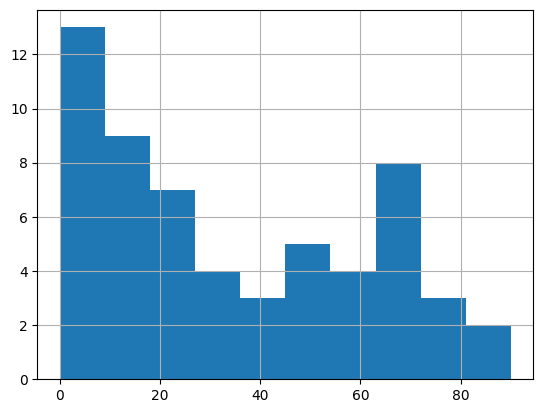

In [10]:
print('Target distribution histogram: ')
print(hist1['Aktywność cytoprotekcyjna [%]'].hist())

In [11]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 4


In [12]:
hist2

,molecular descriptor name,corr_value,absolute correlation value
362,ATSC4s,-0.482595,0.482595
530,GATS2Z,-0.472027,0.472027
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327


In [13]:
with_standarization, train_r2__, test_r2__, hist1_, hist2_ = prepare_data_and_create_model(molecular_descriptors_df, 0.46, True, 5)

I am doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i


C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\1179623727.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  to_be_returned['Aktywność cytoprotekcyjna [%]'] = dataframe['Aktywność cytoprotekcyjna [%]']


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


In [14]:
with_standarization.get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 5,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [15]:
with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']])

array([25.        , 45.        , 65.        ,  6.66666667,  6.66666667,
       27.        ,  6.33333333,  0.        ,  6.66666667, 90.        ,
       80.        , 38.09090909, 38.09090909, 38.09090909,  8.6       ,
       31.25      , 45.        ,  0.        ,  8.6       ,  8.6       ,
        6.33333333,  0.        , 27.        ,  6.66666667,  6.66666667,
        6.66666667,  8.6       ,  5.        , 70.        , 31.25      ,
       25.        , 70.        , 49.        , 30.        , 31.25      ,
       38.09090909, 70.        , 90.        , 66.66666667, 60.        ,
       80.        , 66.66666667, 66.66666667, 38.09090909, 38.09090909,
       38.09090909, 38.09090909, 38.09090909, 38.09090909, 38.09090909,
        8.6       , 31.25      , 49.        , 27.        ,  6.33333333,
       27.        , 27.        , 31.25      ])

In [16]:
len(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]))

58

In [17]:
xs = r2_score(with_standarization.predict(molecular_descriptors_df[hist2_['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])

In [18]:
xs

0.7661868572375442

Target distribution histogram: 
AxesSubplot(0.125,0.11;0.775x0.77)


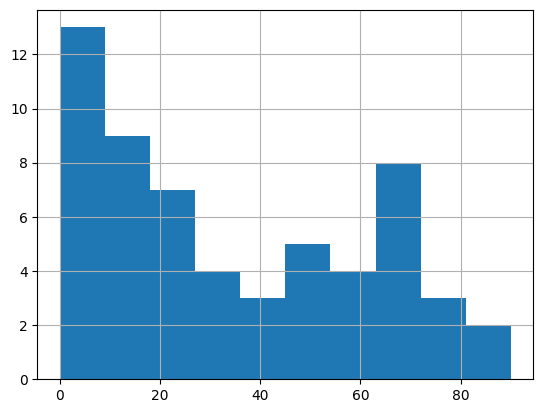

In [19]:
print('Target distribution histogram: ')
print(hist1_['Aktywność cytoprotekcyjna [%]'].hist())

In [20]:
print("Number of features (molecular descriptors used): "+ str(len(hist2)))

Number of features (molecular descriptors used): 4


In [21]:
hist2_

,molecular descriptor name,corr_value,absolute correlation value
362,ATSC4s,-0.482595,0.482595
530,GATS2Z,-0.472027,0.472027
646,MATS1Z,-0.464299,0.464299
652,MATS1m,-0.462327,0.462327


## Search inside correlation space

In [22]:
step = 0.01
initial_step = 0.3
last_step = 0.48
first_list = [x / 100.0 for x in range(int(initial_step*100), int(last_step*100), int(step*100))]
max_depth = [range(2, 30, 1)]
corr_th = []
second_list = []
third_list = []
f_list = []
fif_list = []
for i in first_list:
    for depth in max_depth[0]:
        
        without_standarization, train_r2, test_r2, _, h_ = prepare_data_and_create_model(molecular_descriptors_df, i, False, depth)
        corr_th.append(i)
        second_list.append(train_r2)
        third_list.append(test_r2)
        f_list.append(len(h_))
        fif_list.append(depth)


I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7            

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
7                    AATS0pe    0.329845                    0.329845
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
18     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
1                   AATS0are    0.342320                    0.342320
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
8                     AATS0s    0.350131                    0.350131
9                    AATS0se    0.363989                    0.363989
12                  AATS1are    0.352396                    0.352396
20                   AATS1se    0.363608                    0.363608
30     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
9                    AATS0se    0.363989                    0.363989
20                   AATS1se    0.363608                    0.363608
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
   molecular descriptor name  corr_value  absolute correlation value
30                    AATS2s    0.407553                    0.407553
74                    AATS6s    0.427231                    0.427231
89                 AATSC0are    0.390300                    0.390300
92                  AATSC0dv    0.384705                    0.384705
96     

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
89                  AATSC0are    0.390300                    0.390300
100                   AATSC1Z   -0.435685                    0.435685
10

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[N

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
30                     AATS2s    0.407553                    0.407553
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
14

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
35

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
74                     AATS6s    0.427231                    0.427231
100                   AATSC1Z   -0.435685                    0.435685
106                   AATSC1m   -0.428122                    0.428122
145                   AATSC4s   -0.431682                    0.431682
36

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
100                   AATSC1Z   -0.435685                    0.435685
145                   AATSC4s   -0.431682                    0.431682
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
53

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
476               EState_VSA1    0.444408                    0.444408
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
64

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
    molecular descriptor name  corr_value  absolute correlation value
362                    ATSC4s   -0.482595                    0.482595
530                    GATS2Z   -0.472027                    0.472027
536                    GATS2m   -0.450097                    0.450097
646                    MATS1Z   -0.464299                    0.464299
65

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
646                          MATS1Z   -0.464299                    0.464299
652                          MATS1m   -0.462327 

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Use

  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\530292337.py:21: RuntimeWarning: invalid value encountered in sqrt
  sqrt_r2 = np.sqrt(r2_score(pred, y_test))
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595
530                          GATS2Z   -0.472027                    0.472027
1137  Aktywność cytoprotekcyjna [%]    1.000000                    1.000000
    molecular descriptor name  corr_value  absol

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [23]:
df_without_standarization = pd.DataFrame(data=corr_th, columns=["Correlation threshold"])

In [24]:
df_without_standarization['Training data R^2 score'] = second_list
df_without_standarization['Test data R^2 score'] = third_list
df_without_standarization['Number of features'] = f_list
df_without_standarization['Depth number'] = fif_list

In [25]:
df_without_standarization

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
0,0.30,0.678879,-3.569129,87,2
1,0.30,0.788044,-3.743412,87,3
2,0.30,0.896489,0.430098,87,4
3,0.30,0.941031,-2.274653,87,5
4,0.30,0.971260,-1.688066,87,6
...,...,...,...,...,...
499,0.47,1.000000,0.548767,2,25
500,0.47,1.000000,0.548767,2,26
501,0.47,1.000000,0.548767,2,27
502,0.47,1.000000,0.548767,2,28


## Plots

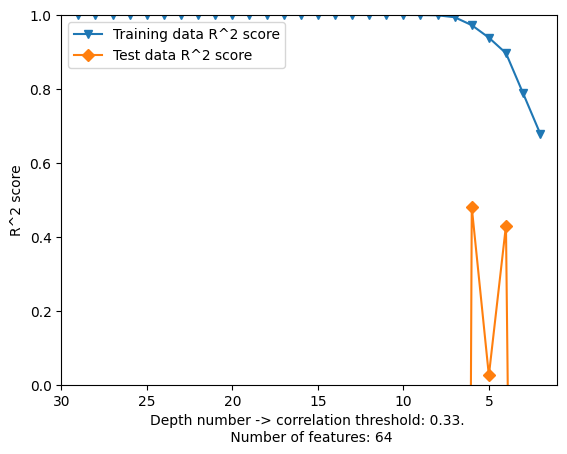

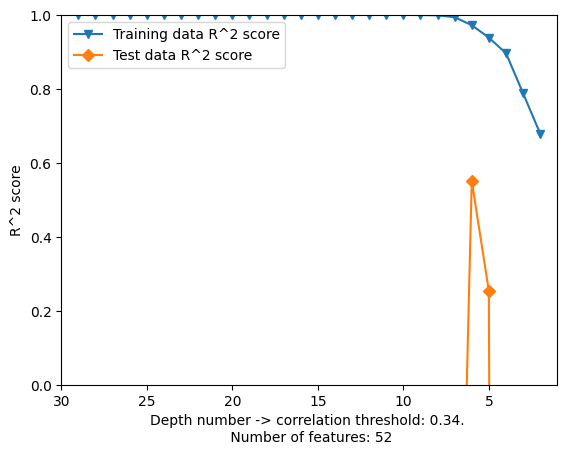

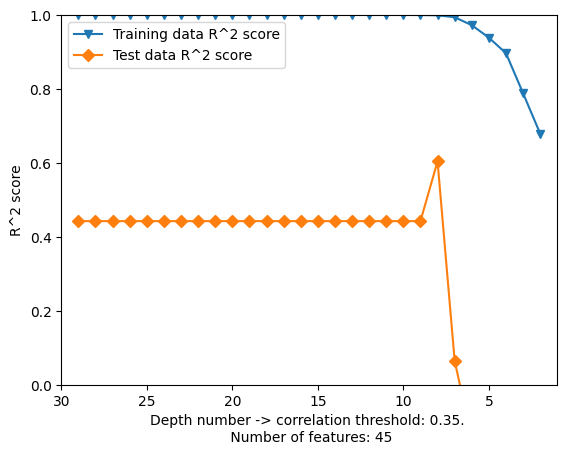

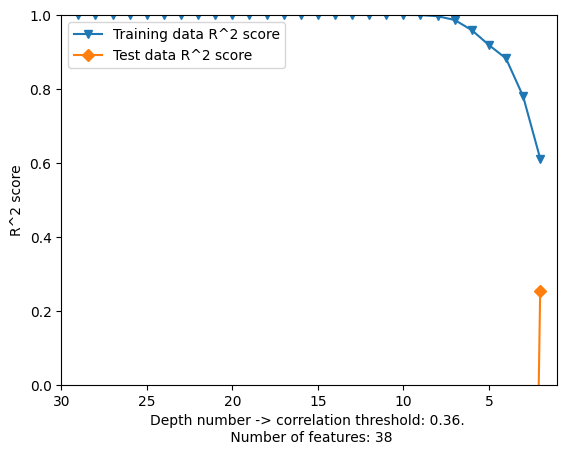

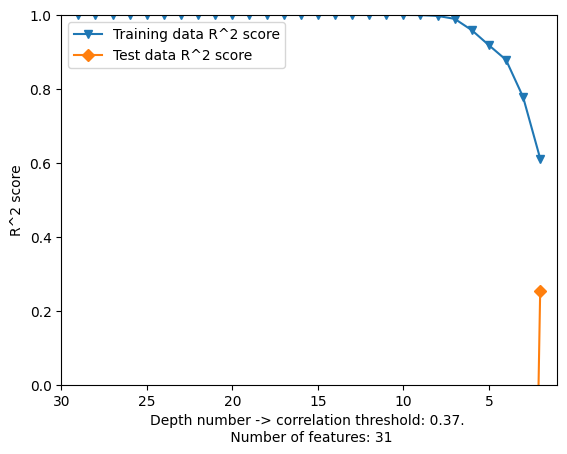

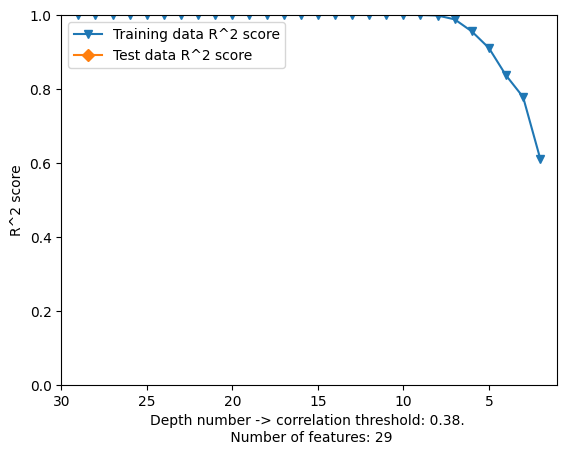

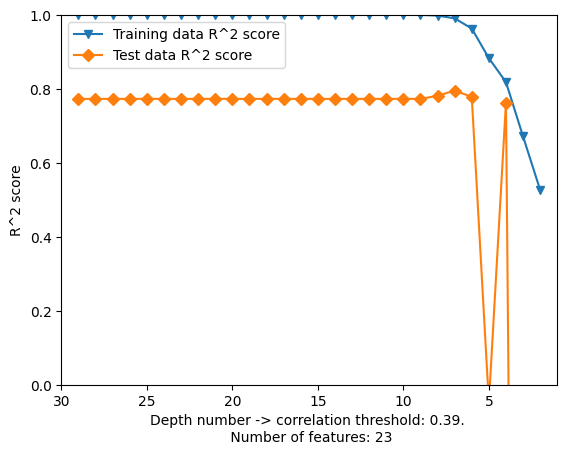

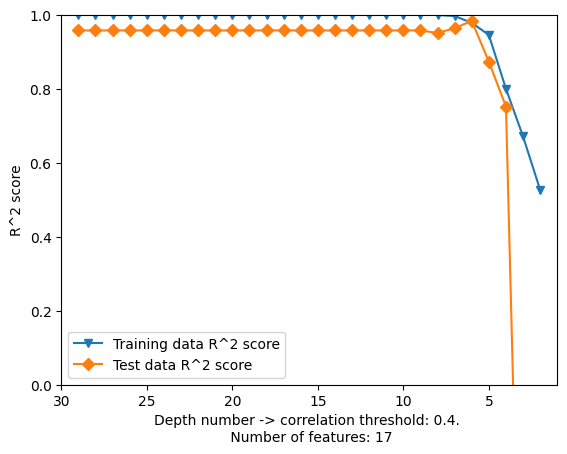

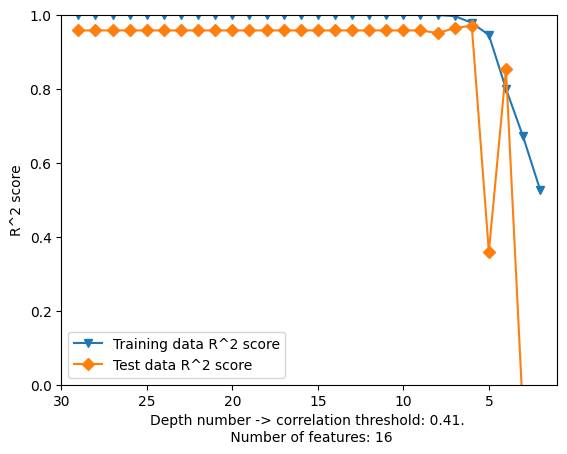

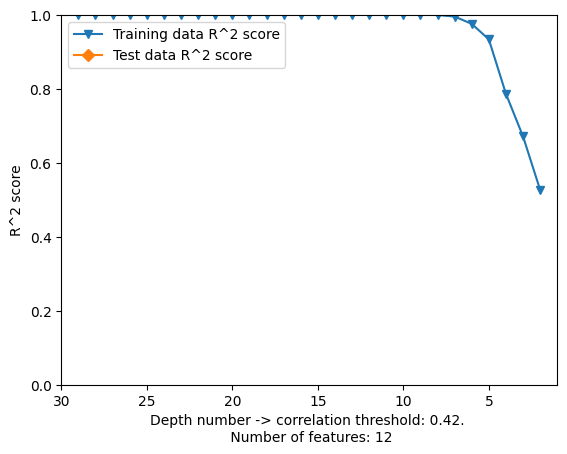

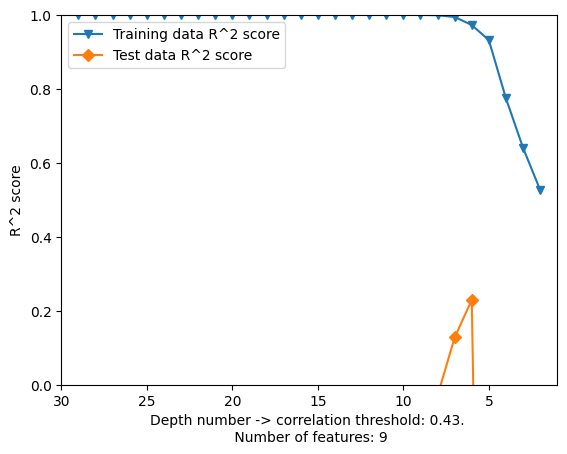

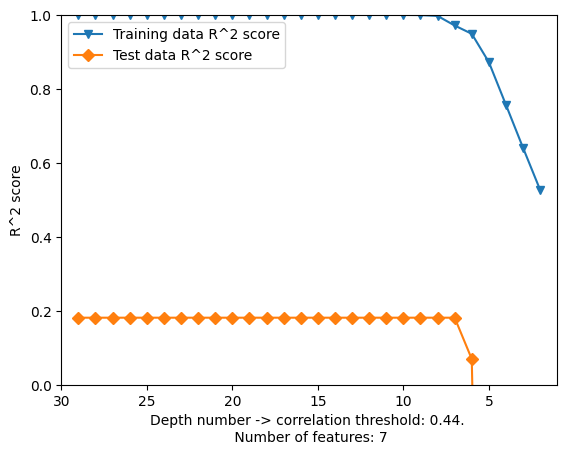

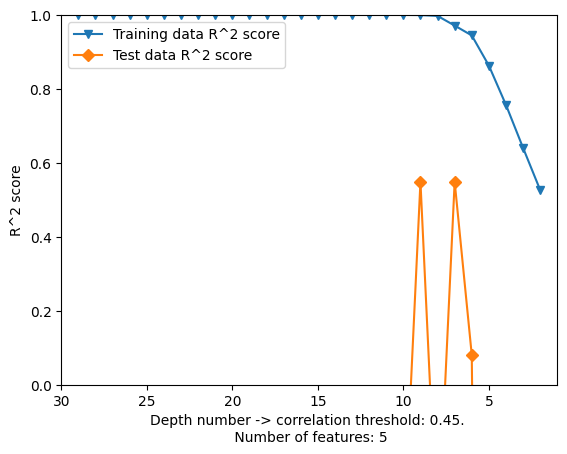

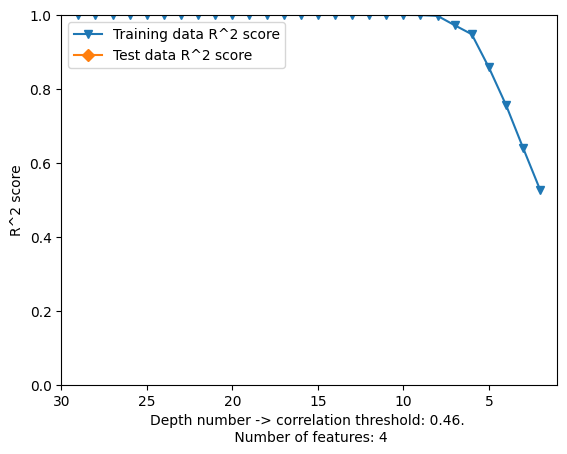

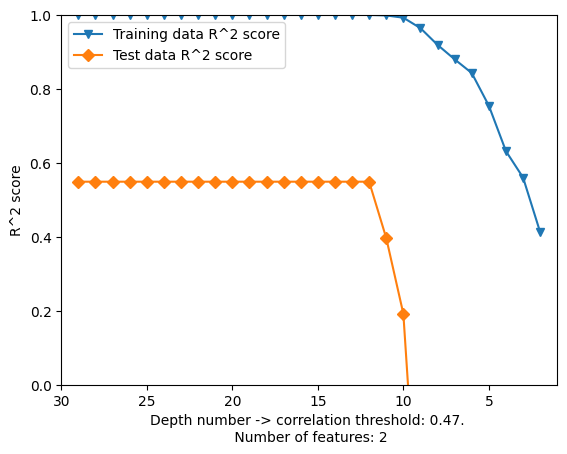

In [26]:
corre_list = [x / 100.0 for x in range(int(0.33*100), int(0.48*100), int(0.01*100))]
for element in corre_list:
    element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == float(element)]
    plt.plot(element_['Depth number'], element_['Training data R^2 score'], label = "Training data R^2 score", marker='v')
    plt.plot(element_['Depth number'], element_['Test data R^2 score'], label = "Test data R^2 score", marker='D')
    plt.legend()
    plt.xlabel('Depth number -> correlation threshold: '+str(element)+'. \n Number of features: '+str(element_['Number of features'].iloc[0]))
    plt.xlim(max(element_['Depth number'])+1, min(element_['Depth number'])-1)
    plt.ylabel('R^2 score')
    plt.ylim([0, 1])
    plt.show()

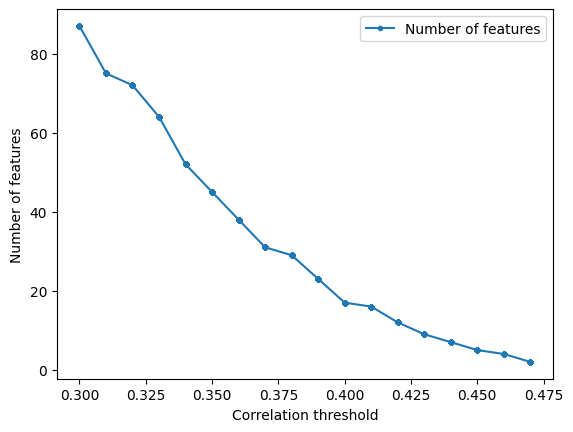

In [27]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

In [28]:
element_ = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]
element_

,Correlation threshold,Training data R^2 score,Test data R^2 score,Number of features,Depth number
476,0.47,0.412094,-2.945716,2,2
477,0.47,0.559968,-3.625109,2,3
478,0.47,0.631331,-1.411351,2,4
479,0.47,0.754322,-0.890772,2,5
480,0.47,0.842760,-1.655093,2,6
481,0.47,0.879845,-0.467956,2,7
482,0.47,0.918938,-0.129568,2,8
483,0.47,0.964258,-0.515919,2,9
484,0.47,0.992493,0.191429,2,10
485,0.47,0.998568,0.396418,2,11


# sqrt(R^2)

In [29]:
r_a = df_without_standarization[df_without_standarization['Correlation threshold'] == 0.47]

In [30]:
r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\1725905962.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_a['train R value'] = [np.sqrt(x) for x in r_a['Training data R^2 score']]


In [31]:
xcz = []
for element in r_a['Test data R^2 score']:
    x = np.sqrt(element)
    try:
        if x > 0:
            xcz.append(x)
        else:
            xcz.append(0)
    except:
        pass
    

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\1103940851.py:3: RuntimeWarning: invalid value encountered in sqrt
  x = np.sqrt(element)


In [32]:
xcz

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0.4375255094603872,
 0.6296172729903153,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598,
 0.7407881770706598]

In [33]:
r_a['test R value'] = xcz

C:\Users\aleks\AppData\Local\Temp\ipykernel_20744\2716572536.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  r_a['test R value'] = xcz


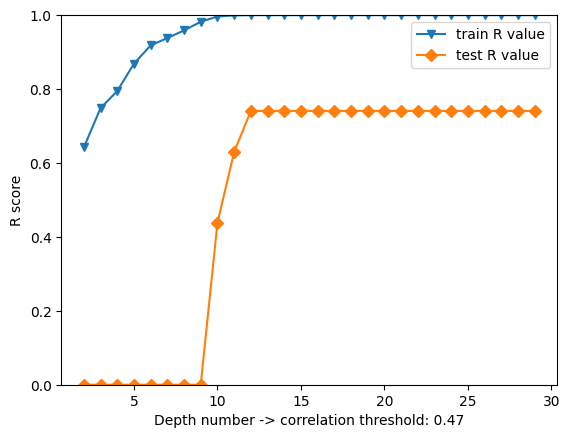

In [34]:
plt.plot(r_a['Depth number'], r_a['train R value'], label = "train R value", marker='v')
plt.plot(r_a['Depth number'], r_a['test R value'], label = "test R value", marker='D')
plt.legend()
plt.xlabel('Depth number -> correlation threshold: 0.47')
plt.ylabel('R score')
plt.ylim([0, 1])
plt.show()

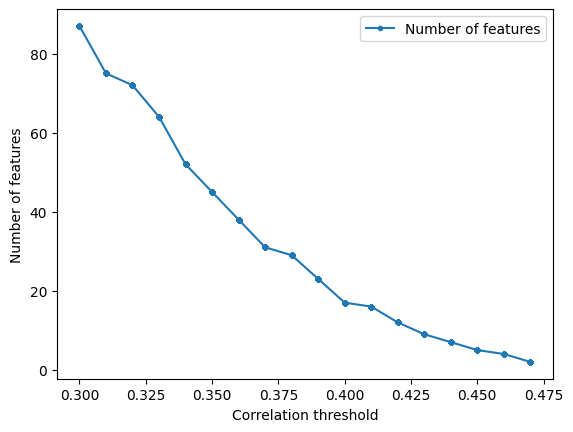

In [35]:
plt.plot(df_without_standarization['Correlation threshold'], df_without_standarization['Number of features'], label = "Number of features", marker='.')
plt.legend()
plt.xlabel('Correlation threshold')
plt.ylabel('Number of features')
plt.show()

## Final model

In [36]:
final_model = prepare_data_and_create_model(molecular_descriptors_df, 0.47, False, 12)

I am not doing standarization...
  molecular descriptor name
0                    AATS0Z
1                  AATS0are
2                    AATS0d
3                   AATS0dv
4                    AATS0i
  molecular descriptor name  corr_value
0                    AATS0Z    0.087615
1                  AATS0are    0.342320
2                    AATS0d    0.109619
3                   AATS0dv    0.266240
4                    AATS0i    0.017757
  molecular descriptor name  corr_value  absolute correlation value
0                    AATS0Z    0.087615                    0.087615
1                  AATS0are    0.342320                    0.342320
2                    AATS0d    0.109619                    0.109619
3                   AATS0dv    0.266240                    0.266240
4                    AATS0i    0.017757                    0.017757
          molecular descriptor name  corr_value  absolute correlation value
362                          ATSC4s   -0.482595                    0.482595

C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2853: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
C:\Users\aleks\anaconda3\envs\cheminf_gpu\lib\site-packages\numpy\lib\function_base.py:2854: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


In [37]:
final_model[0].get_params()

{'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': 12,
 'max_features': None,
 'max_leaf_nodes': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'random_state': 15,
 'splitter': 'best'}

In [38]:
final_model[0]

DecisionTreeRegressor(max_depth=12, random_state=15)

In [39]:
final_model[0].tree_

In [40]:
final_model[4]['molecular descriptor name'].to_list()

['ATSC4s', 'GATS2Z']

In [41]:
from sklearn import tree

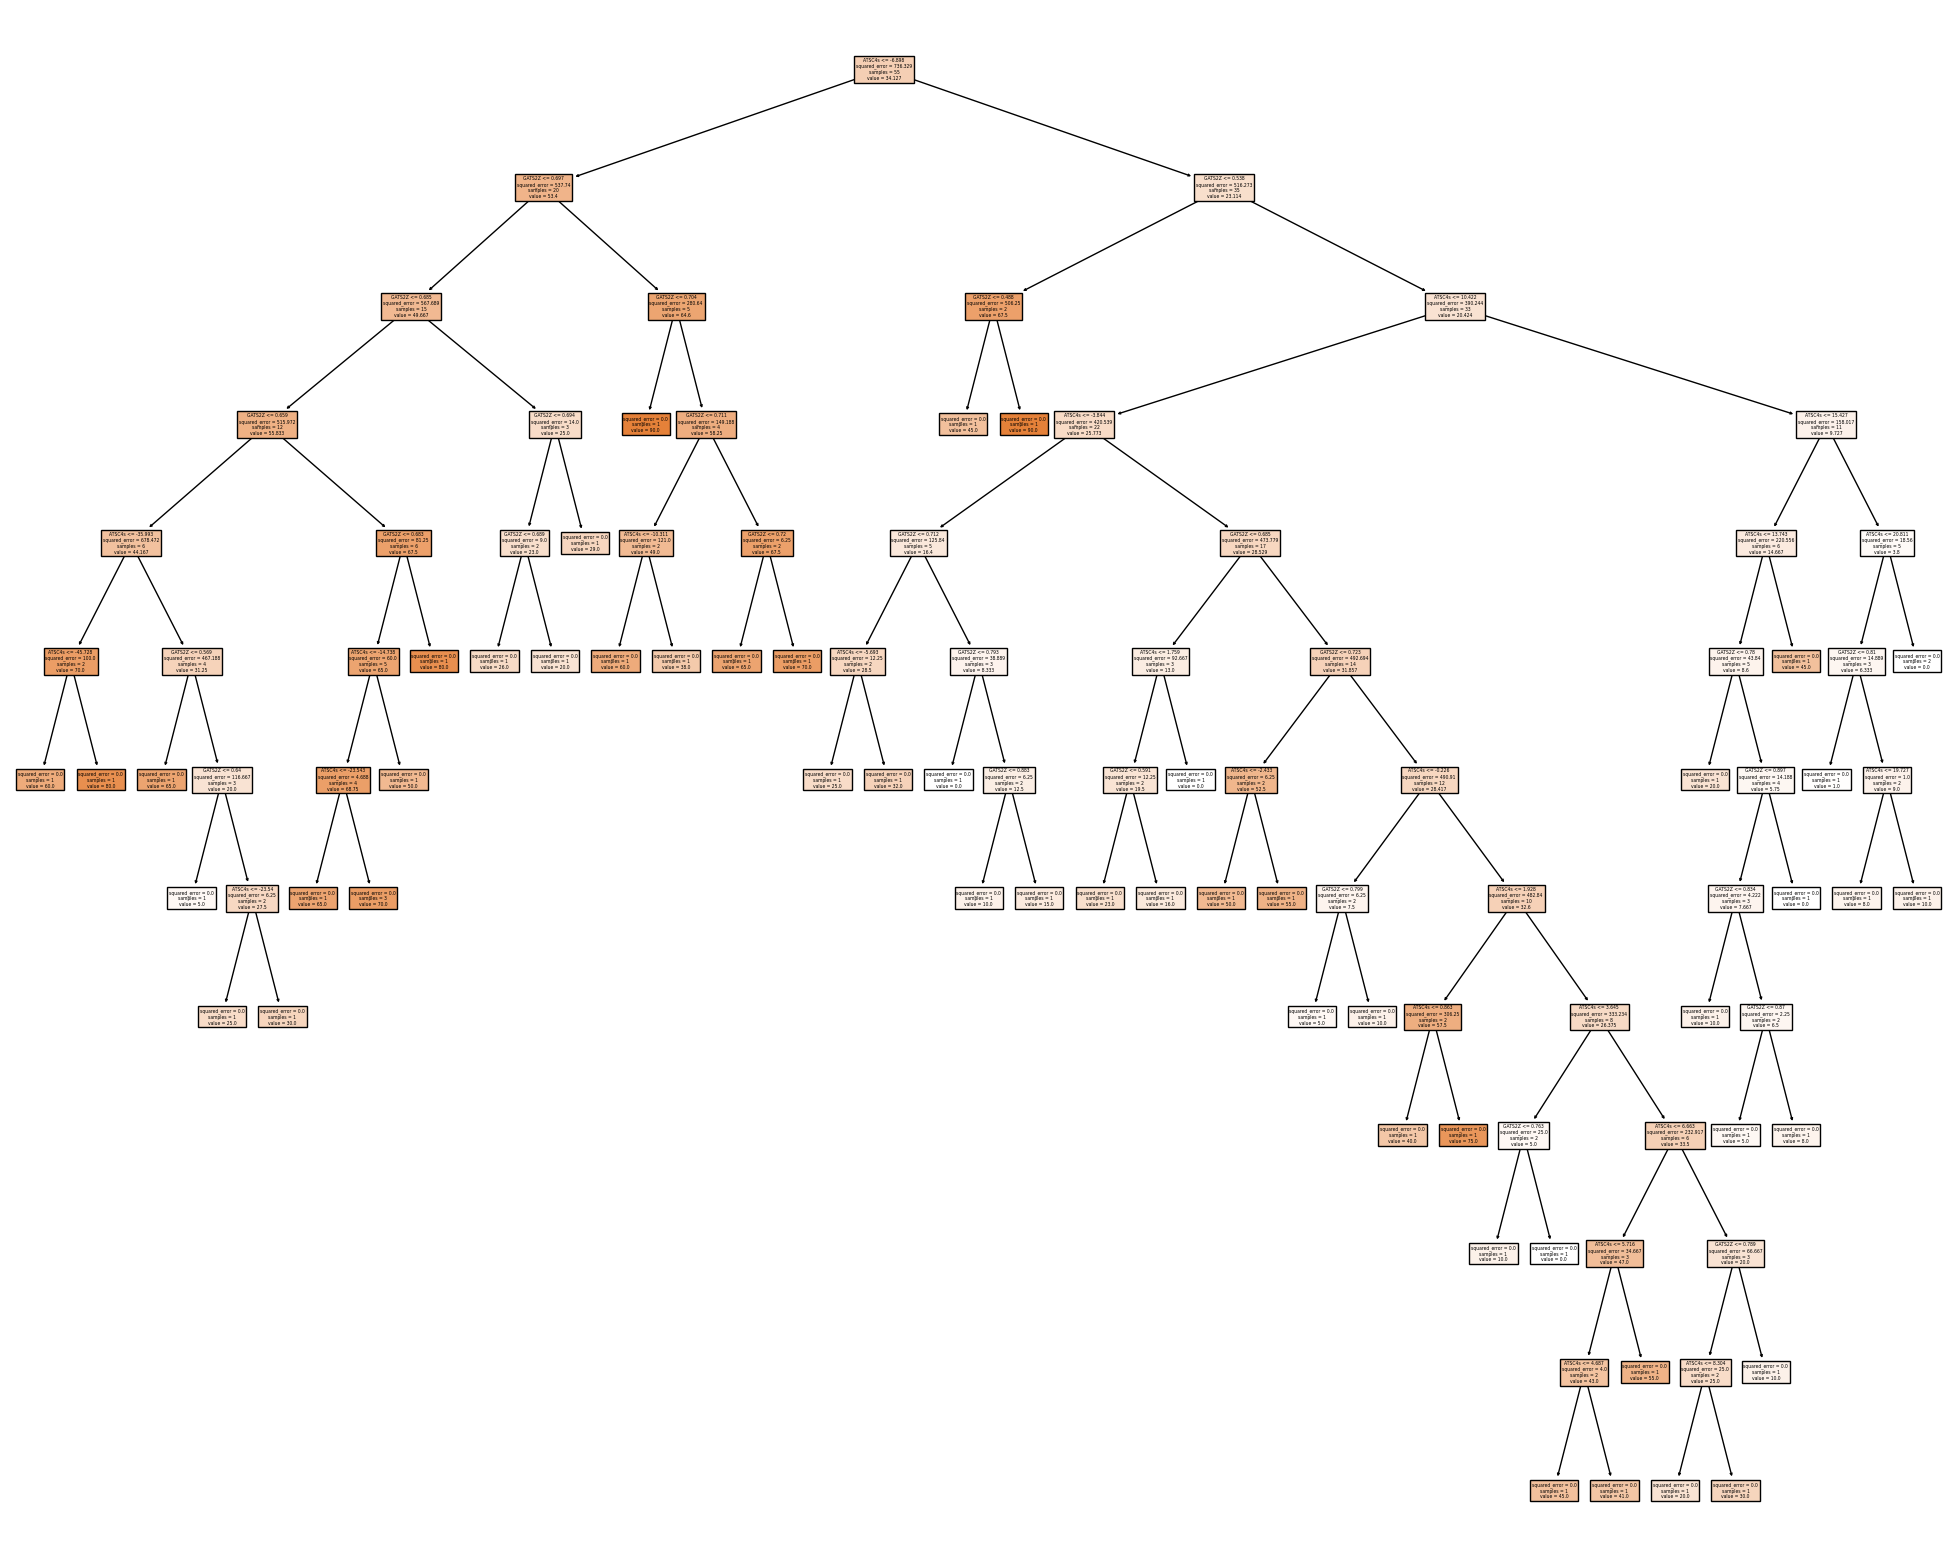

In [42]:
fig = plt.figure(figsize=(25,20))
_ = tree.plot_tree(final_model[0], 
                   feature_names = final_model[4]['molecular descriptor name'].to_list(),
                   filled=True)

In [43]:
# save
joblib.dump(final_model[0], "decision_tree_model.joblib")
# load, no need to initialize the loaded_rf
loaded_rf = joblib.load("decision_tree_model.joblib")

In [44]:
final_model[0].predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']])

array([ 5., 45., 65., 15., 10., 10.,  8.,  0.,  0., 90., 80., 55., 75.,
       55., 10., 50., 45.,  0.,  5.,  0., 10.,  0., 10.,  0.,  5., 10.,
        8.,  5., 70., 20., 25., 70., 60., 30., 50., 50., 70., 90., 70.,
       60., 80., 65., 65., 16., 23., 10., 40., 45., 20., 30., 20., 26.,
       38., 41.,  1., 25., 32., 29.])

In [45]:
molecular_descriptors_df['Aktywność cytoprotekcyjna [%]']

0     12
1     45
2     65
3     15
4     10
5      0
6      8
7      0
8      0
9     90
10    80
11    55
12    75
13    55
14    10
15    50
16    45
17     0
18     5
19     0
20    10
21     0
22    10
23     0
24     5
25    10
26     8
27     5
28    70
29    20
30    25
31    70
32    60
33    30
34    70
35    50
36    70
37    90
38    70
39    60
40    80
41    65
42    65
43    16
44    23
45    10
46    40
47    45
48    20
49    30
50    20
51    26
52    38
53    41
54     1
55    25
56    32
57    29
Name: Aktywność cytoprotekcyjna [%], dtype: int64

In [46]:
xsz = r2_score(final_model[0].predict(molecular_descriptors_df[final_model[4]['molecular descriptor name']]), molecular_descriptors_df['Aktywność cytoprotekcyjna [%]'])
xsz

0.9869770919186152

In [47]:
np.sqrt(xsz)

0.9934672072688736

## Predict target feature

In [48]:
to_prediction = prepare_data('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')

100%|████████████████████████████████████████████████████████████████████████████████| 346/346 [00:04<00:00, 72.63it/s]


(346, 1613)
(346, 1375)
(346, 1219)


In [49]:
predicted_activity = final_model[0].predict(to_prediction[final_model[4]['molecular descriptor name']])

In [50]:
smiles = pd.read_excel('../Data/Proposed_structures_with_AI_caffeine_tanimoto_similarity_.xlsx')
smiles = smiles['new_SMILES']
smiles = smiles.to_list()
save_to_df = pd.DataFrame(data=smiles, columns=['SMILES'])

In [51]:
print(len(smiles))
print(len(predicted_activity))

346
346


In [52]:
save_to_df.head()

,SMILES
0,Cn1c(NCCCN=C2NC(=O)CS2)nc2c1n(C)c(=O)n2C
1,CN1CN=C(NCCCN=C2NC(=O)CS2)N(C)CN(C)C1=O
2,Cn1c(SC(=S)N2CCCC2)nc2c1n(C)c(=O)n2C=O
3,CN1Cc2c(n(C)c(=O)n(C)c2=O)C1NCC=CCCCN=N
4,CCN(C=O)C(=O)C=CN=C(NCCCN=C1NC(=O)CS1)N(C)C


In [53]:
save_to_df['Predicted activity'] = predicted_activity

In [54]:
save_to_df.head()

,SMILES,Predicted activity
0,Cn1c(NCCCN=C2NC(=O)CS2)nc2c1n(C)c(=O)n2C,70.0
1,CN1CN=C(NCCCN=C2NC(=O)CS2)N(C)CN(C)C1=O,70.0
2,Cn1c(SC(=S)N2CCCC2)nc2c1n(C)c(=O)n2C=O,90.0
3,CN1Cc2c(n(C)c(=O)n(C)c2=O)C1NCC=CCCCN=N,70.0
4,CCN(C=O)C(=O)C=CN=C(NCCCN=C1NC(=O)CS1)N(C)C,45.0


In [55]:
save_to_df.to_excel('../Data/Predicted_activity_DT.xlsx')